### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 3 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 03 мая, -4 балла после 08:30 10 мая, -6 баллов после 08:30 17 мая, -8 баллов после 08:30 24 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [2]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1
    
    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        if criterion == 'gini':
            self.info_func = self.__Q_gini
        elif criterion == 'entropy':
            self.info_func = self.__Q_entropy
        elif criterion == 'misclass':
            self.info_func = self.__Q_misclass
        else:
            print('invalid criterion name')
            raise     
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        self.get_feature_ids = self.__get_feature
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2

    def __F_misclass(self, l_c, r_c):
        return 1 - np.maximum(l_c / (l_c + r_c), r_c / (l_c + r_c))
        
    def __Q_misclass(self, l_c, l_s, r_c, r_s):
        return (self.__F_misclass(l_c, r_c) - l_c / (l_c + r_c) * self.__F_misclass(l_s, l_c - l_s)
            - r_c / (l_c + r_c) * self.__F_misclass(r_s, r_c - r_s))
        
    def __F_gini(self, l_c, r_c):
        return (1 - (l_c / (l_c + r_c)) ** 2 - (r_c / (l_c + r_c)) ** 2)
        
    def __Q_gini(self, l_c, l_s, r_c, r_s):
        return (self.__F_gini(l_c, r_c) - l_c / (l_c + r_c) * self.__F_gini(l_s, l_c - l_s)
                - r_c / (l_c + r_c) * self.__F_gini(r_s, r_c - r_s))
        
    def __F_entropy(self, l_c, r_c):
        return (-(l_c / (l_c + r_c)) * np.log2(l_c / (l_c + r_c) + 1e-3)
                - (r_c / (l_c + r_c)) * np.log2(r_c / (l_c + r_c) + 1e-3) )
        
    def __Q_entropy(self, l_c, l_s, r_c, r_s):
        return (self.__F_entropy(l_c, r_c) - l_c / (l_c + r_c) * self.__F_entropy(l_s, l_c - l_s)
            - r_c / (l_c + r_c) * self.__F_entropy(r_s, r_c - r_s))

    
    def __get_feature(self, n_feature):
        feature_ids = np.array(range(n_feature))
        return feature_ids

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]


    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        sortrack = y[0]
        sorted_idx = x.T.argsort(axis=1)
        sorted_x, sorted_y = np.sort(x.T,axis=1), (y[sorted_idx]== sortrack).astype(int)
        b = np.bincount(sorted_y[0])
        len = sorted_y.shape[1]
        l_sums = np.cumsum(sorted_y, axis=1)
        r_sums = b[1] - l_sums
        l = np.array(range(len))
        l_c = np.array(l + np.zeros(sorted_y.shape[0]).reshape(-1, 1))
        l_c[:, 0] += 1
        r_c = len - l_c
        info_matrix = self.info_func(l_c, l_sums, r_c, r_sums)
        ind = np.unravel_index(np.argmax(info_matrix), info_matrix.shape)
        return ((sorted_x[ind[0], ind[1]] + sorted_x[ind[0], ind[1] + 1]) / 2.0,  ind[0], info_matrix[ind[0], ind[1]])
    
    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        ymax, frequency = np.unique(y, return_counts=True)
        ymax.sort()
        probably = frequency / y.size
        ymax = ymax[(-frequency).argsort()]
        if (depth == self.max_depth) or (y.size < self.min_samples_split):
            self.tree[node_id] = (self.__class__.LEAF_TYPE, ymax[0], probably)
        elif np.any(probably >= 1):
            self.tree[node_id] = (self.__class__.LEAF_TYPE, ymax[0], probably)
        else:
            threshold, feature_id, crit = self.__find_threshold(x, y)
            self.tree[node_id] = (self.__class__.NON_LEAF_TYPE, feature_id, threshold)
            xl, xr, yl, yr = self.__div_samples(x, y, feature_id, threshold)
            if yl.size > 0 and yr.size > 0:
                self.__fit_node(xl, yl, 2 * node_id + 1, depth + 1)
                self.__fit_node(xr, yr, 2 * node_id + 2, depth + 1)
                self.feature_importances_[feature_id] += y.size * crit / self.fit_count
            else:
                self.tree[node_id] = (self.__class__.LEAF_TYPE, ymax[0], probably)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.features_ids = self.get_feature_ids(x.shape[1])
        self.fit_count = x.shape[0]
        self.num_class = np.unique(y).size
        self.feature_importances_ = np.zeros(x.shape[1])
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feature_importances_
    


In [3]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [6]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

0.8333333333333334

In [7]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.9444444444444444

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [10]:
%time clf.fit(X_train, y_train)

Wall time: 709 µs


DecisionTreeClassifier()

In [11]:
%time my_clf.fit(X_train, y_train)

Wall time: 3.76 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [12]:
df = pd.read_csv('Speed Dating Data.csv',
                 encoding='cp1251')
df = df.iloc[:, :97]
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)
df.drop_duplicates(subset=['iid']).gender.value_counts()
df = df.drop(['condtn'], axis=1)
df = df.drop(['round'], axis=1)
df = df.drop(['position', 'positin1'], axis=1)
df = df.drop(['order'], axis=1)
df = df.drop(['partner'], axis=1)
df = df.drop(['age_o', 'race_o', 'pf_o_att',
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o'],
             axis=1)
df = df.dropna(subset=['age'])
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(0)
df = df.drop(['field'], axis=1)
pd.get_dummies(df, columns=['field_cd'],
               prefix='field_cd', prefix_sep='=')
df = df.drop(['undergra'], axis=1)
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df.loc[:, 'mn_sat'] = df.mn_sat.fillna(-999)
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', 
                                                    '').astype(np.float)
df.loc[:, 'tuition'] = df.tuition.fillna(-999)
df = df.dropna(subset=['imprelig', 'imprace'])
df = df.drop(['from', 'zipcode'], axis=1)
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-999)
df = df.dropna(subset=['date'])
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(0)
df = df.drop(['career'], axis=1)
df = df.drop(['sports', 'tvsports', 'exercise',
              'dining', 'museums', 'art', 'hiking',
              'gaming', 'clubbing', 'reading', 'tv',
              'theater', 'movies', 'concerts',
              'music', 'shopping', 'yoga'], axis=1)
df = df.drop(['expnum'], axis=1)
df.loc[:, 'temp_totalsum'] = df.loc[:, [
    'attr1_1', 'sinc1_1', 'intel1_1',
    'fun1_1', 'amb1_1', 'shar1_1'
]].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1',
           'intel1_1', 'fun1_1',
           'amb1_1', 'shar1_1']] = \
    (df.loc[:, ['attr1_1', 'sinc1_1',
                'intel1_1', 'fun1_1',
                'amb1_1', 'shar1_1']].T / df.loc[:, 'temp_totalsum'].T).T * 100
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1',
                                        'intel2_1', 'fun2_1',
                                        'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1',
           'intel2_1', 'fun2_1',
           'amb2_1', 'shar2_1']] = \
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1',
                'amb2_1', 'shar2_1']].T / df.loc[:, 'temp_totalsum'].T).T * 100
df = df.drop(['temp_totalsum'], axis=1)
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i),
            'intel{}_1'.format(i), 'fun{}_1'.format(i),
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]

    if i != 4:
        feat.remove('shar{}_1'.format(i))

    df = df.drop(feat, axis=1)
df = df.drop(['wave'], axis=1)
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid']) \
    .drop(['gender'], axis=1) \
    .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid']) \
    .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1) \
    .dropna()

df_female.columns = df_female.columns + '_f'
df_female = df_female.drop(['pid_f'], axis=1)
df_pair = df_male.join(df_female.set_index('iid_f'),
                       on='pid',
                       how='inner')
df_pair = df_pair.drop(['iid', 'pid'], axis=1)
X = df_pair.iloc[:, 1:].values
y = df_pair.iloc[:, 0].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [14]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [15]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [17]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

0.7628787878787879

In [16]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8174242424242424

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [18]:
kf=KFold(10)

In [19]:
result=0
for train, test in kf.split(X):
    my_clftest = MyDecisionTreeClassifier(min_samples_split=2,criterion='gini')
    my_clftest.fit(X[train],y[train])
    y_p=my_clftest.predict(X[test])
    result+=accuracy_score(y_p,y[test])
result/=10
result

0.8364630325814536

In [20]:
result=0
for train, test in kf.split(X):
    my_clftest = MyDecisionTreeClassifier(min_samples_split=2,criterion='entropy')
    my_clftest.fit(X[train],y[train])
    y_p=my_clftest.predict(X[test])
    result+=accuracy_score(y_p,y[test])
result/=10
result

<ipython-input-2-f403004ae698>:52: RuntimeWarning: invalid value encountered in log2
  - (r_c / (l_c + r_c)) * np.log2(r_c / (l_c + r_c) + 1e-3) )


0.8362130325814536

In [21]:
result=0
for train, test in kf.split(X):
    my_clftest = MyDecisionTreeClassifier(min_samples_split=2,criterion='misclass')
    my_clftest.fit(X[train],y[train])
    y_p=my_clftest.predict(X[test])
    result+=accuracy_score(y_p,y[test])
result/=10
result

0.8359605263157895

In [23]:
kf=KFold(10)

In [24]:
results=[]
for depth in range(1,50):
    result=0
    for train, test in kf.split(X):
        my_clftest = MyDecisionTreeClassifier(max_depth=depth,min_samples_split=2,criterion='gini')
        my_clftest.fit(X[train],y[train])
        y_p=my_clftest.predict(X[test])
        result+=accuracy_score(y_p,y[test])
    result/=10
    results.append(result)

In [25]:
results

[0.8364630325814536,
 0.8364630325814536,
 0.8364630325814536,
 0.8364630325814536,
 0.8359605263157895,
 0.8239467418546367,
 0.8147005012531328,
 0.7916998746867168,
 0.7756973684210526,
 0.7654473684210528,
 0.7646967418546367,
 0.7626973684210527,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684210528,
 0.7614473684

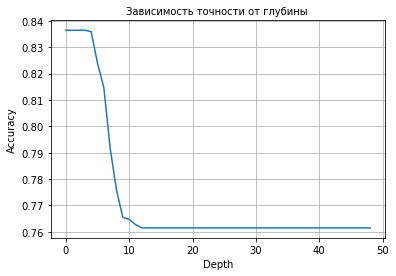

In [26]:
fig, ax = plt.subplots()
plt.title('Зависимость точности от глубины ', fontsize=10)
ax.grid()
ax.set_xlabel('Depth')
ax.set_ylabel('Accuracy')
plt.plot(results) 

plt.show()

In [27]:
kf=KFold(5)

In [28]:
results_splits=[]
for spl in range(2,50):
    res=0
    for train, test in kf.split(X):
        my_clf = MyDecisionTreeClassifier(max_depth=4, min_samples_split=spl,criterion='gini')
        my_clf.fit(X[train],y[train])
        y_p=my_clf.predict(X[test])
        res+=accuracy_score(y_p,y[test])       
    res/=5
    results_splits.append(res)

In [29]:
results_splits

[0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757196495,
 0.8364605757

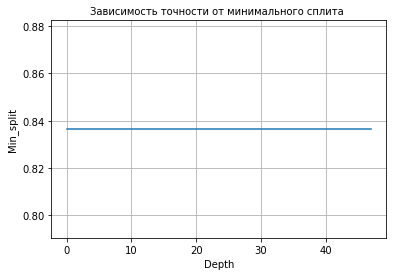

In [30]:
fig, ax = plt.subplots()
plt.title('Зависимость точности от минимального сплита ', fontsize=10)
ax.grid()
ax.set_xlabel('Depth')
ax.set_ylabel('Min_split')
plt.plot(results_splits) 

plt.show()

Странное поведение, в середине работы над домашкой этот кусок кода выдавал не константный результат,
и наилучшие сплиты были в районе 2-3-4.
Под конец работы почему-то стало выдавать константу, не могу понять, что не так:((((

In [31]:
my_clf = MyDecisionTreeClassifier(max_depth=4, min_samples_split=2,criterion='gini')

In [32]:
my_clf.fit(X_train, y_train)

In [33]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8265151515151515

Финальный скор при глубине 4 и мин сплите 2 получается в районе 0.825

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [35]:
sr = pd.Series(data=my_clf.feature_importances_, index=df_pair.columns[1:])
sr.div(sr.sum()).sort_values(ascending=False).head(10)

fun1_1_f    0.244699
fun2_1_f    0.151951
fun3_1      0.151748
sinc1_1     0.095407
age_f       0.069897
date        0.062700
int_corr    0.046693
amb1_1      0.036574
date_f      0.034074
sinc3_1     0.029770
dtype: float64

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



Ох, сложная домашка, если честно. Очень долго с ней сидел.
Со скоростью всё хорошо, с точностью тоже, под конец только разбиение по сплитам забарахлило.
Курс под конец семестра всё сложнее и интереснее, многие вещи касательно деревьев и ансамблей, которые 
я читал до поступления, теперь стали намного яснее.